In [ ]:
# default_exp forecaster

In [ ]:
# hide
import sys

sys.path.append("..")

# Forecaster

> Uses a trained `Model`/`Learner` to predict future samples.

Mostly copied from <https://github.com/MSRDL/Deep4Cast>

In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *


/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# export
class Forecaster():
    """Handles training of a PyTorch model and can be used to generate samples
    from approximate posterior predictive distribution.
    Arguments:
        * model (``torch.nn.Module``): Instance of Deep4cast :class:`models`.
        * device (str): Device used for training (`cpu` or `cuda`).
        * verbose (bool): Verbosity of forecaster.
    
    """
    def __init__(self,
                 model,
                 device='cpu',
                 verbose=True):
        self.device = device if torch.cuda.is_available() and 'cuda' in device else 'cpu'
        self.model = model.to(device)
        self.history = {'training': [], 'validation': []}
        self.verbose = verbose

    def predict(self, dataloader, n_samples=100) -> np.array:
        """Generates predictions.
        Arguments:
            * dataloader (``torch.utils.data.DataLoader``): Data to make forecasts.
            * n_samples (int): Number of forecast samples.
        
        """
        with torch.no_grad():
            predictions = []
            for batch in dataloader:
                inputs = batch[0].to(self.device)
                samples = []
                for i in range(n_samples):
                    y = self.model(inputs)
#                     outputs = self.loss(**outputs).sample((1,)).cpu()
#                     y = outputs[0]
    
#                     outputs = copy.deepcopy(batch)
#                     outputs = dataloader.dataset.transform.untransform(outputs)
                    samples.append(y[None, :])
                samples = np.concatenate(samples, axis=0)
                predictions.append(samples)
            predictions = np.concatenate(predictions, axis=1)

        return predictions

    def embed(self, dataloader, n_samples=100) -> np.array:
        """Generate embedding vectors.
        Arguments:
            * dataloader (``torch.utils.data.DataLoader``): Data to make embedding vectors.
            * n_samples (int): Number of forecast samples.
        
        """
        with torch.no_grad():
            predictions = []
            for batch in dataloader:
                inputs = batch['X'].to(self.device)
                samples = []
                for i in range(n_samples):
                    outputs, __ = self.model.encode(inputs)
                    samples.append(outputs.cpu().numpy())
                samples = np.array(samples)
                predictions.append(samples)
            predictions = np.concatenate(predictions, axis=1)

        return predictions
    

# Test

In [ ]:
horizon = 12
lookback = 128

In [ ]:
# hide
from fastseq.data.load import *
from fastseq.data.transforms import *
from fastai2.data.all import *
from fastseq.models.wavenet import *

In [ ]:
t = np.arange(1000)
lenghts = np.random.randint(10,500,100)
data_train = [np.array([i+.5*np.sin(t[:l]),
              t[:l]+(0.1*np.random.randn()),
             ])
              for i,l in enumerate(lenghts)]

# print([d.shape for d in data_train])

In [ ]:
ts_ds = TimeSeriesDataset(
    data_train,
    lookback,
    horizon,
    step=1,
    static_covs = [1,2,2,2,2],
    transform = ToTensor()
)
ts_dl = DataLoader(
    ts_ds,
    batch_size=64,
    shuffle=True,
    pin_memory=True,
    num_workers=1
)

In [ ]:
# hide
model = WaveNet(input_channels=2,
                output_channels=1,
                horizon=horizon,                    
               )
predictor = Forecaster(model)
predictor.predict(ts_dl, n_samples=1).shape

(1, 13804, 1, 12)

In [ ]:
model = WaveNet(input_channels=2,
                output_channels=2,
                horizon=horizon,
                    
               )

print('Number of model parameters: {}.'.format(model.n_parameters))
print('Receptive field size: {}.'.format(model.receptive_field_size))

# # .. and the loss
# loss = torch.distributions.StudentT

Number of model parameters: 125076.
Receptive field size: 128.


In [ ]:
data = DataBunch(ts_dl, ts_dl).cuda()
learn = Learner(data, model, loss_func=F.mse_loss, opt_func=Adam, metrics=accuracy)

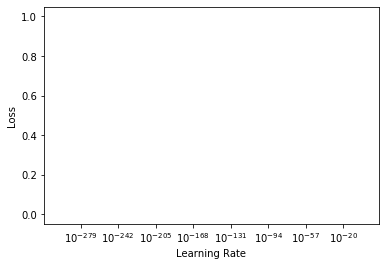

In [ ]:
from fastai2.callback.all import *
learn.lr_find()

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
This cell doesn't have an export destination and was ignored:
 
Converted 02_deep4cast_m4_example.ipynb.
Converted 03_data.load.ipynb.
Converted 04_data.transforms.ipynb.
Converted 05_models.wavenet.ipynb.
Converted index.ipynb.
